Cередня кількість поїздок для кожного дня тижня за останній місяць

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

# Create SparkSession
spark = SparkSession.builder \
    .appName("SimpleApp") \
    .getOrCreate()



your 131072x1 screen size is bogus. expect trouble
25/04/15 12:04:58 WARN Utils: Your hostname, DESKTOP-DP2FLCF resolves to a loopback address: 127.0.1.1; using 172.22.104.161 instead (on interface eth0)
25/04/15 12:04:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/15 12:05:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/15 12:05:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [13]:
df_fare_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_fare_1.csv")
df_trip_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_data_1.csv")

In [14]:
for column in df_fare_init.columns:
    df_fare_init = df_fare_init.withColumnRenamed(column, column.strip().replace(" ", "_"))

In [17]:
from pyspark.sql.functions import to_date, lit

df_trip = df_trip_init.filter(
    (col("passenger_count") > 0) & (col("passenger_count") <= 10) &
    (col("trip_time_in_secs") > 0) &
    (col("trip_distance") > 0) &
    (col("pickup_latitude").between(40.5, 41.0)) &
    (col("dropoff_latitude").between(40.5, 41.0)) &
    (col("pickup_longitude").between(-74.5, -73.0)) &
    (col("dropoff_longitude").between(-74.5, -73.0)) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)

df_fare = df_fare_init.filter(
    (col("fare_amount") >= 0) &
    (col("tip_amount") >= 0) &
    (col("tolls_amount") >= 0) &
    (col("total_amount") >= 0) &
    ((col("fare_amount") > 0) | (col("payment_type") == "NOC")) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)

In [ ]:
from pyspark.sql.functions import max, min, col, to_date, trunc

df = df_trip.join(df_fare, on=["medallion", "hack_license", "pickup_datetime", "vendor_id"])

# max_date = df.select(max("pickup_datetime")).first()[0]

In [27]:
from pyspark.sql.functions import col, date_sub, max as Fmax, date_format, count, avg

# 1. Знайти останню дату
# last_date = df_trip.select(Fmax("pickup_datetime")).first()[0]
last_date = df_trip.select(Fmax("pickup_datetime")).first()[0]
print(last_date)

2013-01-27 00:00:00


In [37]:
from pyspark.sql import functions as F
# 2. Фільтруємо останні 30 днів
# df_month = df_trip.filter(
#     (col("pickup_datetime") >= date_sub(F.lit(last_date), 30)) &
#     (col("pickup_datetime") <= F.lit(last_date))
# )

# 3. Додаємо колонку з днем тижня
df_month = df_trip.withColumn("weekday", date_format("pickup_datetime", "EEEE"))

# 4. Групуємо по даті й дню тижня — для підрахунку поїздок на кожен день
df_daily_counts = df_month.withColumn("date", date_format("pickup_datetime", "yyyy-MM-dd")) \
    .groupBy("date", "weekday").agg(count("*").alias("trip_count"))

# 5. Рахуємо середню кількість поїздок по кожному дню тижня
df_avg_by_weekday = df_daily_counts.groupBy("weekday").agg(avg("trip_count").alias("avg_trips"))

# 6. Сортуємо дні тижня (не обов’язково, але красиво)
from pyspark.sql.functions import when

# Додаємо порядковий номер для сортування
df_avg_by_weekday = df_avg_by_weekday.withColumn("order", when(col("weekday") == "Monday", 1)
                                                 .when(col("weekday") == "Tuesday", 2)
                                                 .when(col("weekday") == "Wednesday", 3)
                                                 .when(col("weekday") == "Thursday", 4)
                                                 .when(col("weekday") == "Friday", 5)
                                                 .when(col("weekday") == "Saturday", 6)
                                                 .when(col("weekday") == "Sunday", 7))

df_avg_by_weekday.orderBy("order").select("weekday", "avg_trips").show()


+---------+---------+
|  weekday|avg_trips|
+---------+---------+
|   Monday|411385.75|
|  Tuesday| 453808.0|
|Wednesday| 365242.0|
| Thursday|481592.25|
|   Friday| 507664.0|
| Saturday|500409.75|
|   Sunday|433244.25|
+---------+---------+



/tmp/ipykernel_26153/3005829803.py:10: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="weekday", y="avg_trips", data=pdf, palette="Blues_d")


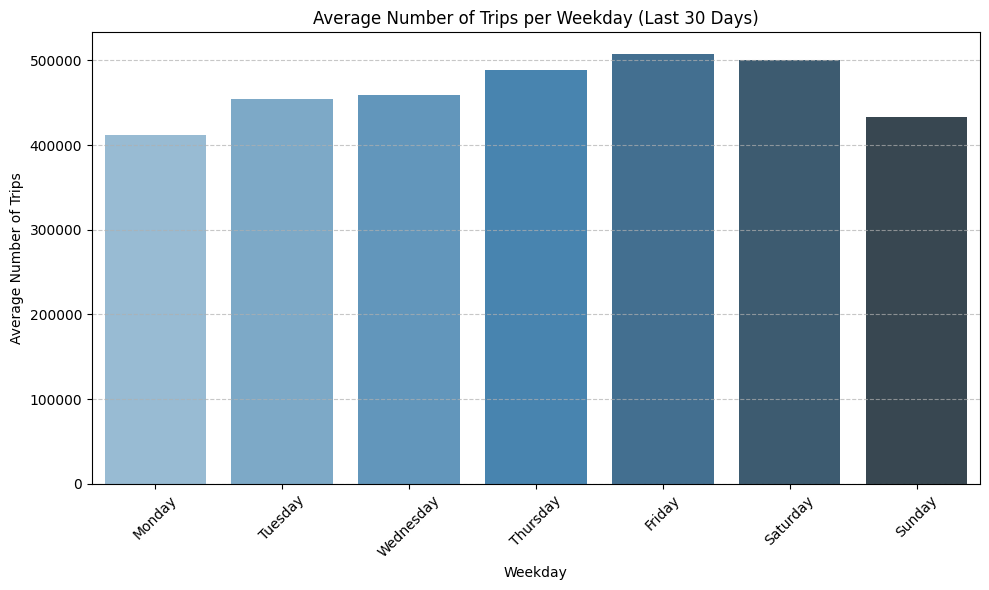

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools

# 1. Перетворюємо Spark DataFrame у Pandas DataFrame
pdf = df_avg_by_weekday.orderBy("order").select("weekday", "avg_trips").toPandas()

# 2. Будуємо графік
plt.figure(figsize=(10, 6))
sns.barplot(x="weekday", y="avg_trips", data=pdf, palette="Blues_d")

plt.title("Average Number of Trips per Weekday (Last 30 Days)")
plt.xlabel("Weekday")
plt.ylabel("Average Number of Trips")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import to_date, date_format, count, avg, max as Fmax, date_sub, col, lit

df_last_month = df_trip.withColumn("trip_date", to_date("pickup_datetime")) \
    .withColumn("weekday", date_format("trip_date", "EEEE"))

daily_counts = df_last_month.groupBy("trip_date", "weekday").agg(
    count("*").alias("daily_trip_count")
)

avg_by_weekday = daily_counts.groupBy("weekday").agg(
    avg("daily_trip_count").alias("avg_trip_count")
).orderBy("weekday")

In [ ]:
from pyspark.sql.functions import when

ordered = avg_by_weekday.withColumn("weekday_order", 
    when(col("weekday") == "Monday", 1)
    .when(col("weekday") == "Tuesday", 2)
    .when(col("weekday") == "Wednesday", 3)
    .when(col("weekday") == "Thursday", 4)
    .when(col("weekday") == "Friday", 5)
    .when(col("weekday") == "Saturday", 6)
    .when(col("weekday") == "Sunday", 7)
)

ordered.orderBy("weekday_order").drop("weekday_order").show(truncate=False)


+---------+--------------+
|weekday  |avg_trip_count|
+---------+--------------+
|Monday   |401752.0      |
|Tuesday  |450732.5      |
|Wednesday|456523.0      |
|Thursday |481592.25     |
|Friday   |507664.0      |
|Saturday |500409.75     |
|Sunday   |424398.0      |
+---------+--------------+



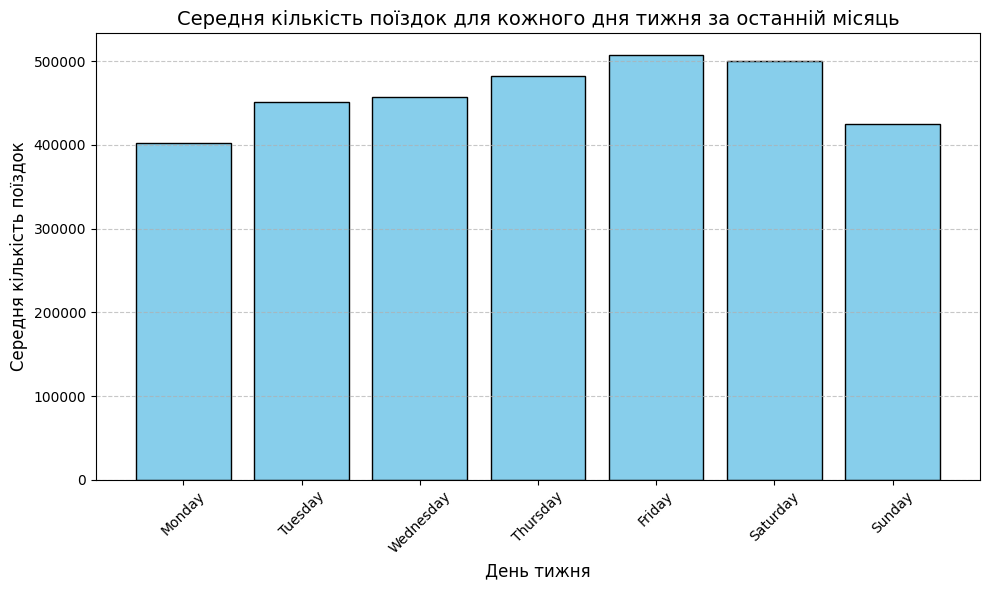

In [24]:
pandas_df = ordered.orderBy("weekday_order").toPandas()
import matplotlib.pyplot as plt

days = pandas_df["weekday"]
avg_trips = pandas_df["avg_trip_count"]

# Побудова графіка
plt.figure(figsize=(10, 6))
plt.bar(days, avg_trips, color='skyblue', edgecolor='black')

# Підпис та стиль
plt.title("Cередня кількість поїздок для кожного дня тижня за останній місяць", fontsize=14)
plt.xlabel("День тижня", fontsize=12)
plt.ylabel("Середня кількість поїздок", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показ графіка
plt.tight_layout()
plt.show()

